# Comstock Dataset Exploration

Source: https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/metadata_and_annual_results/by_state/state=CA/csv/CA_baseline_metadata_and_annual_results.csv

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [52]:
def load_data() -> pd.DataFrame:
    # Note: this dataset will need to be imported from the site due to the large file size
    filepath = "Dataset/CA_baseline_metadata_and_annual_results.csv"
    df = pd.read_csv(filepath)
    return df

df = load_data()

C:\Users\cheun\AppData\Local\Temp\ipykernel_25252\1745216684.py:3: DtypeWarning: Columns (57,578,585,850) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [53]:
def clean_datatypes(df: pd.DataFrame):
    df = df.copy()
    filepath = "Dataset/data_dictionary.tsv"
    MAPPER = {
        "string": str,
        "integer": int,
        "float": float,
        "boolean": bool
    }
    header_df = pd.read_csv(filepath, sep="\t")
    assert set(header_df["data_type"].unique()) == set(MAPPER.keys())
    header_df["data_type"] = header_df["data_type"].apply(lambda x: MAPPER[x])
    datatypes = header_df[["field_name", "data_type"]].to_dict(orient="records")
    datatypes = {d["field_name"]: d["data_type"] for d in datatypes}
    for col in df.columns:
        cleaned_col = col.split("..")[0]
        try:
            df[col] = df[col].astype(datatypes[cleaned_col])
        except Exception as e:
            df[col] = df[col].astype(float)
    return df

def clean_data(df: pd.DataFrame):
    df = clean_datatypes(df)
    return df

cleaned_df = clean_data(df)

In [54]:
def explore_data_unbiased(df: pd.DataFrame):
    columns = list(df.columns)
    print("columns:", [col for col in columns if not col.startswith("in.") and not col.startswith("out.") and not col.startswith("calc.")])
    print("in columns:", [col for col in columns if col.startswith("in.")])
    print("out columns:", [col for col in columns if col.startswith("out.")])
    print("calc columns:", [col for col in columns if col.startswith("calc.")])
    print("Num Records:", df.shape[0])


explore_data_unbiased(cleaned_df)


columns: ['bldg_id', 'metadata_index', 'upgrade', 'weight', 'applicability']
in columns: ['in.sqft', 'in.upgrade_name', 'in.building_america_climate_zone', 'in.cambium_grid_region', 'in.census_division_name', 'in.census_region_name', 'in.cluster_id', 'in.cluster_name', 'in.county_name', 'in.iso_rto_region', 'in.nhgis_county_gisjoin', 'in.nhgis_puma_gisjoin', 'in.nhgis_tract_gisjoin', 'in.reeds_balancing_area', 'in.state', 'in.state_name', 'in.airtightness..m3_per_m2_s', 'in.ashrae_iecc_climate_zone_2006', 'in.aspect_ratio', 'in.building_subtype', 'in.cejst_is_disadvantaged', 'in.comstock_building_type', 'in.comstock_building_type_group', 'in.economizer_changeover_temperature_fault_applicable', 'in.economizer_damper_stuck_fault_applicable', 'in.economizer_damper_stuck_fault_timing', 'in.ejscreen_census_tract_percentile_for_demographic_index', 'in.ejscreen_census_tract_percentile_for_less_than_hs_educ', 'in.ejscreen_census_tract_percentile_for_low_income', 'in.ejscreen_census_tract_perce

In [61]:
def split_X_y(df: pd.DataFrame):
    X = df[[col for col in df.columns if col.startswith("in.") or col.startswith("calc.") and not col.startswith("calc.enduse_group") and not col.startswith("calc.emissions")]]
    y = df[[col for col in df.columns if col.startswith("out.") or col.startswith("calc.enduse_group") or col.startswith("calc.emissions")]]
    return X, y

X, y = split_X_y(cleaned_df)

In [64]:
def split_test_train(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_test_train(X, y)

In [79]:
def explore_data(X_train: pd.DataFrame, y_train: pd.DataFrame):
    display(X_train.head())
    display(y_train.head())
    
explore_data(X_train, y_train)

,in.sqft,calc.weighted.sqft,in.upgrade_name,in.building_america_climate_zone,in.cambium_grid_region,in.census_division_name,in.census_region_name,in.cluster_id,in.cluster_name,in.county_name,...,calc.weighted.savings.natural_gas.interior_equipment.energy_consumption..tbtu,calc.weighted.savings.natural_gas.total.energy_consumption..tbtu,calc.weighted.savings.natural_gas.water_systems.energy_consumption..tbtu,calc.weighted.savings.other_fuel.cooling.energy_consumption..tbtu,calc.weighted.savings.other_fuel.heating.energy_consumption..tbtu,calc.weighted.savings.other_fuel.interior_equipment.energy_consumption..tbtu,calc.weighted.savings.other_fuel.total.energy_consumption..tbtu,calc.weighted.savings.other_fuel.water_systems.energy_consumption..tbtu,calc.weighted.savings.site_energy.total.energy_consumption..tbtu,calc.weighted.site_energy.total.energy_consumption..tbtu
3611,7500.0,6.544544e+04,Baseline,Hot-Dry,CAMXc,Pacific,West,113,CA Climate Zone 13,"CA, Kern County",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003415
23334,350000.0,1.133274e+06,Baseline,Hot-Dry,CAMXc,Pacific,West,110,CA Climate Zone 10,"CA, San Bernardino County",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013508
15209,17500.0,3.273641e+04,Baseline,Hot-Dry,CAMXc,Pacific,West,110,CA Climate Zone 10,"CA, San Bernardino County",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004591
7174,17500.0,3.273641e+04,Baseline,Hot-Dry,CAMXc,Pacific,West,109,CA Climate Zone 9,"CA, Los Angeles County",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002388
29888,37500.0,1.201719e+05,Baseline,Hot-Dry,CAMXc,Pacific,West,110,CA Climate Zone 10,"CA, Riverside County",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009482


,out.district_cooling.cooling.energy_consumption,out.district_cooling.cooling.energy_savings,out.district_cooling.total.energy_consumption,out.district_cooling.total.energy_savings,out.district_heating.cooling.energy_consumption,out.district_heating.cooling.energy_savings,out.district_heating.heating.energy_consumption,out.district_heating.heating.energy_savings,out.district_heating.total.energy_consumption,out.district_heating.total.energy_savings,...,calc.enduse_group.other_fuel.hvac.energy_consumption..kwh,calc.enduse_group.other_fuel.interior_equipment.energy_consumption..kwh,calc.enduse_group.other_fuel.water_systems.energy_consumption..kwh,calc.enduse_group.site_energy.cooling.energy_consumption..kwh,calc.enduse_group.site_energy.heating.energy_consumption..kwh,calc.enduse_group.site_energy.hvac.energy_consumption..kwh,calc.enduse_group.site_energy.interior_equipment.energy_consumption..kwh,calc.enduse_group.site_energy.lighting.energy_consumption..kwh,calc.enduse_group.site_energy.refrigeration.energy_consumption..kwh,calc.enduse_group.site_energy.water_systems.energy_consumption..kwh
3611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22197.222222,11916.666667,71861.111111,18161.111111,21858.333333,0.0,2822.222222
23334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,513972.222222,517297.222222,479566.666667,219997.222222,0.0,5797.222222
15209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,144875.000000,44283.333333,342911.111111,244783.333333,70877.777778,0.0,60636.111111
7174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,77519.444444,107236.111111,278575.000000,23419.444444,67719.444444,0.0,4411.111111
29888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,248850.000000,198686.111111,641022.222222,130288.888889,92408.333333,0.0,3472.222222


In [85]:
def plot_scatter(x, y, savefig: bool = False):
    fig, axes = plt.subplots(figsize=(3, 3))
    graph_df = pd.concat([X_train[x], y_train[y]], axis=1)
    sns.scatterplot(data=graph_df, x=x, y=y)
    plt.xlabel(x, fontsize=6)
    plt.ylabel(y, fontsize=6)
    plt.title(f"{y} vs.\n{x}", fontsize=8)
    if savefig:
        os.makedirs("results")
        filepath = "results/{y}__{x}.png"
        plt.savefig(filepath)
    plt.show()

def plot_bar(x, y, savefig: bool = False):
    fig, axes = plt.subplots(figsize=(3, 3))
    graph_df = pd.concat([X_train[x], y_train[y]], axis=1)
    sns.barplot(data=graph_df, x=x, y=y)
    plt.xlabel(x, fontsize=6)
    plt.ylabel(y, fontsize=6)
    plt.title(f"{y} vs.\n{x}", fontsize=8)
    if savefig:
        os.makedirs("results")
        filepath = "results/{y}__{x}.png"
        plt.savefig(filepath)
    plt.show()

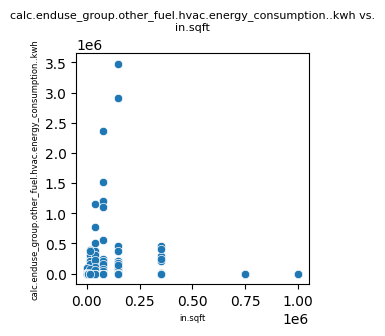

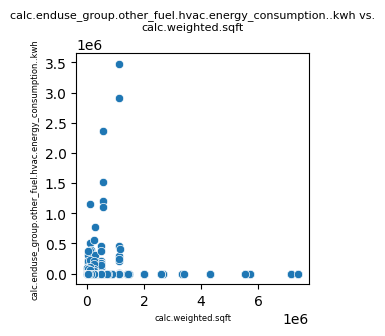

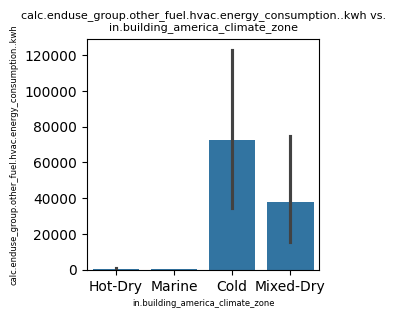

In [86]:
plot_scatter("in.sqft", "calc.enduse_group.other_fuel.hvac.energy_consumption..kwh")
plot_scatter("calc.weighted.sqft", "calc.enduse_group.other_fuel.hvac.energy_consumption..kwh")
plot_bar("in.building_america_climate_zone", "calc.enduse_group.other_fuel.hvac.energy_consumption..kwh")